In [4]:
# 1. Setup
                                                                             
import os
import math
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 5)

# Optional: use dask for out-of-core processing on larger-than-memory datasets
try:
    import dask.dataframe as dd
    DASK_AVAILABLE = True
except Exception:
    DASK_AVAILABLE = False

# File path - change to your large CSV/TSV file
DATA_PATH = 'household_power_consumption_semicolon.csv'  # <--- change this to your file

# If your file uses the exact header from sample, delimiter=';'
DELIMITER = ';'

# Quick configuration for pandas read
PANDAS_READ_PARAMS = {
    'sep': DELIMITER,
    'decimal': '.',
    'low_memory': False,
}

# For reproducibility
RANDOM_STATE = 42


In [8]:
# 2. Fast read + parse (pandas)

# Column names from your sample
cols = [
    'Date', 'Time', 'Global_active_power', 'Global_reactive_power', 'Voltage',
    'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'
]

# dtype hints - read as strings first for numeric conversion later (safer when missing vals exist)
dtype_hints = {c: 'float64' for c in cols if c not in ('Date', 'Time')}

# Recommended approach for ~2M rows: pandas with parse_dates using a combined column
parse_dates = False

if DASK_AVAILABLE:
    print('Dask is available. You can use Dask for out-of-core processing if desired.')

# Try to read with pandas but avoid parse_dates (we'll combine afterwards) for speed
print('Reading a small sample to infer parsing behavior...')
sample = pd.read_csv(DATA_PATH, sep=DELIMITER, nrows=1000, header=0)
print('Sample loaded: columns ->', sample.columns.tolist())

# Now read full dataset - if memory is sufficient, do full pandas read
try:
    print('Attempting full pandas read...')
    df = pd.read_csv(DATA_PATH, sep=DELIMITER, header=0, na_values=['?', 'NA', ''], low_memory=False)
    print('Pandas read successful. Rows:', len(df))
except Exception as e:
    print('Pandas read failed or memory heavy. Falling back to Dask if available. Error:', e)
    if DASK_AVAILABLE:
        df = dd.read_csv(DATA_PATH, sep=DELIMITER, header=0, na_values=['?', 'NA', ''])
        print('Dask dataframe created.')
    else:
        raise


Dask is available. You can use Dask for out-of-core processing if desired.
Reading a small sample to infer parsing behavior...
Sample loaded: columns -> ['Date', 'Time', 'Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
Attempting full pandas read...
Pandas read successful. Rows: 2075259


In [9]:
# 3. Cleaning & parsing DateTime

def combine_and_parse_datetime(df_local):
    # df_local may be pandas or dask
    if isinstance(df_local, pd.DataFrame):
        # Combine Date and Time into a single datetime column
        df_local['Datetime'] = pd.to_datetime(df_local['Date'].astype(str) + ' ' + df_local['Time'].astype(str),
                                              dayfirst=True, errors='coerce')
        df_local = df_local.drop(columns=['Date', 'Time'])
        # Convert numeric columns to floats, coerce errors
        for col in ['Global_active_power','Global_reactive_power','Voltage','Global_intensity',
                    'Sub_metering_1','Sub_metering_2','Sub_metering_3']:
            df_local[col] = pd.to_numeric(df_local[col], errors='coerce')
        # Set index
        df_local = df_local.set_index('Datetime')
        # Sort by index
        df_local = df_local.sort_index()
        return df_local
    else:
        # Dask dataframe
        df_local['Datetime'] = dd.to_datetime(df_local['Date'].astype(str) + ' ' + df_local['Time'].astype(str),
                                              dayfirst=True, errors='coerce')
        df_local = df_local.drop(columns=['Date', 'Time'])
        for col in ['Global_active_power','Global_reactive_power','Voltage','Global_intensity',
                    'Sub_metering_1','Sub_metering_2','Sub_metering_3']:
            df_local[col] = df_local[col].astype(float)
        df_local = df_local.set_index('Datetime')
        df_local = df_local.map_partitions(lambda p: p.sort_index())
        return df_local

print('Parsing datetimes and converting types...')
df = combine_and_parse_datetime(df)
print('Index dtype:', df.index.dtype)

# If Dask, compute basic length
if DASK_AVAILABLE and not isinstance(df, pd.DataFrame):
    try:
        print('Number of rows (approx):', df.shape[0].compute())
    except Exception:
        print('Skipped computing row count (expensive).')
else:
    print('Number of rows:', len(df))

Parsing datetimes and converting types...
Index dtype: datetime64[ns]
Number of rows: 2075259


In [10]:
# 4. Basic summary statistics & missing values
if isinstance(df, pd.DataFrame):
    display(df.head())
    print('\nBasic info:')
    print(df.info())
    print('\nMissing values per column:')
    print(df.isna().sum())
    print('\nNumeric summary:')
    display(df.describe())
else:
    print('Dask: computing head and summary (this triggers computation).')
    display(df.head().compute())
    print('Missing values per column (computed):')
    print(df.isna().sum().compute())


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0



Basic info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB
None

Missing values per column:
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

Numeric summary:


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


In [11]:
# 5. Handling missing values

if isinstance(df, pd.DataFrame):
    df = df[~df.index.isna()]
    # forward-fill then backward-fill for small gaps
    df_ffill = df.fillna(method='ffill').fillna(method='bfill')
    # For any remaining NAs (start/end), fill with median
    df_ffill = df_ffill.fillna(df_ffill.median())
    df = df_ffill
    print('After imputation: missing per column:')
    print(df.isna().sum())
else:
    # Dask strategy - do partition-wise fills then compute small sample to finalize
    df = df.dropna(subset=[] if 'Datetime' not in df.columns else ['Datetime'])
    df = df.map_partitions(lambda p: p.fillna(method='ffill').fillna(method='bfill'))
    # Note: computing medians on Dask requires compute(); we leave it for final compute step if needed.
    print('Dask pipeline set up. Use df.compute() to materialize if desired.')

After imputation: missing per column:
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64


In [12]:
# 6. Exploratory analysis
# Daily and hourly aggregates

def compute_aggregates(df_local):
    if isinstance(df_local, pd.DataFrame):
        hourly = df_local.resample('H').mean()
        daily = df_local.resample('D').mean()
        return hourly, daily
    else:
        hourly = df_local.resample('H').mean().compute()
        daily = df_local.resample('D').mean().compute()
        return hourly, daily

print('Computing hourly and daily aggregates (may take a while)...')
hourly, daily = compute_aggregates(df)
print('Hourly shape:', hourly.shape)
print('Daily shape:', daily.shape)

Computing hourly and daily aggregates (may take a while)...
Hourly shape: (34589, 7)
Daily shape: (1442, 7)


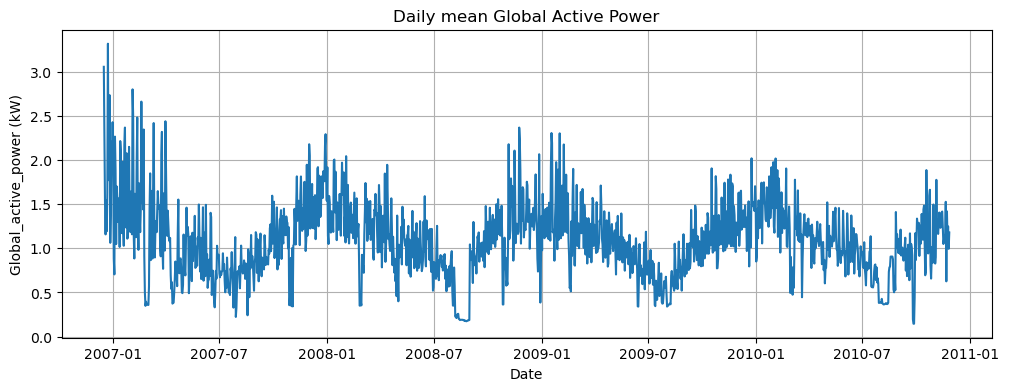

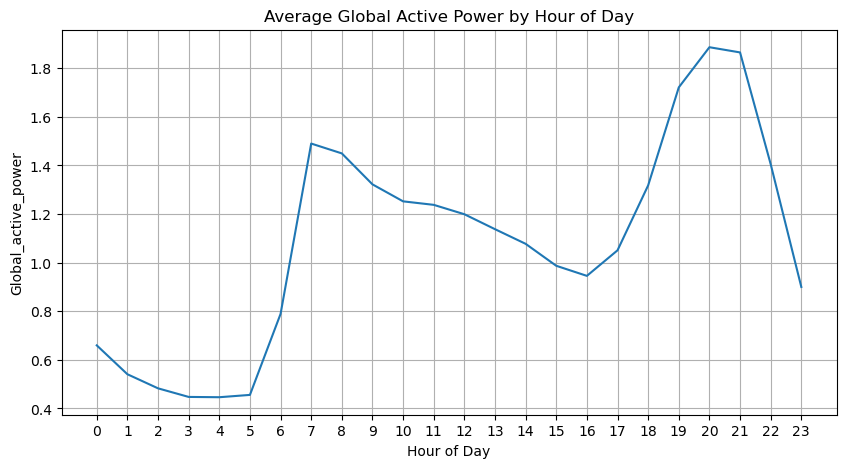

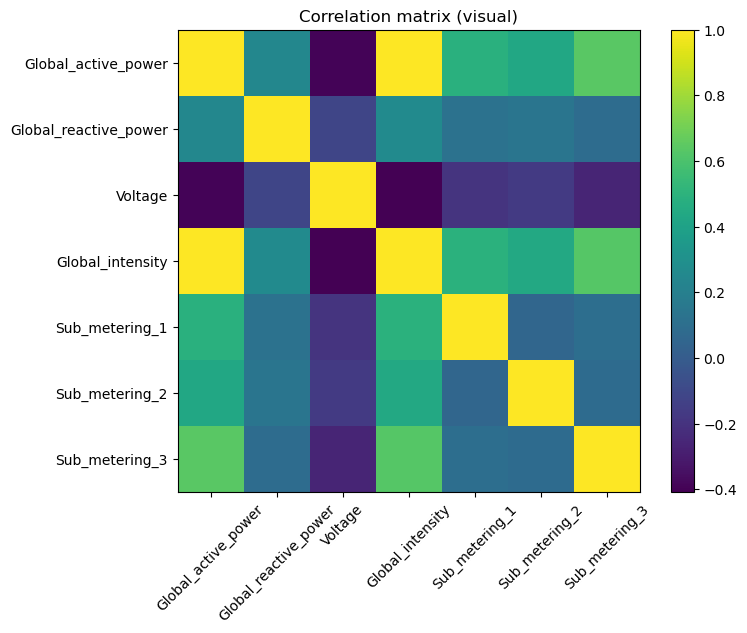

In [13]:
# 7. Visualizations (single-plot-per-cell requirement)

# Global Active Power over time (sampled to daily for a simple plot)
plt.figure(figsize=(12,4))
plt.plot(daily.index, daily['Global_active_power'])
plt.title('Daily mean Global Active Power')
plt.xlabel('Date')
plt.ylabel('Global_active_power (kW)')
plt.grid(True)
plt.show()

# %%
# Hourly pattern: average hour-of-day across dataset
hour_of_day = df.groupby(df.index.hour)['Global_active_power'].mean() if isinstance(df, pd.DataFrame) else df.groupby(df.index.hour)['Global_active_power'].mean().compute()
plt.figure()
plt.plot(hour_of_day.index, hour_of_day.values)
plt.title('Average Global Active Power by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Global_active_power')
plt.xticks(range(0,24))
plt.grid(True)
plt.show()

# %%
# Correlation matrix (visualize numeric correlations as a heatmap)
if isinstance(df, pd.DataFrame):
    corr = df.corr()
else:
    corr = df.corr().compute()

plt.figure(figsize=(8,6))
plt.imshow(corr, interpolation='nearest')
plt.colorbar()
plt.title('Correlation matrix (visual)')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.show()

In [14]:
# 8. Outlier detection (IQR) on Global_active_power

def iqr_outliers(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return (series < lower) | (series > upper)

if isinstance(df, pd.DataFrame):
    outlier_mask = iqr_outliers(df['Global_active_power'])
    print('Outliers detected (Global_active_power):', outlier_mask.sum())
    # mark them
    df['is_outlier_gap'] = outlier_mask
else:
    # Dask - compute a sample of quantiles
    gap = df['Global_active_power']
    q1 = gap.quantile(0.25).compute()
    q3 = gap.quantile(0.75).compute()
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    df = df.assign(is_outlier_gap=(df['Global_active_power'] < lower) | (df['Global_active_power'] > upper))


Outliers detected (Global_active_power): 95699


In [15]:
# 9. Feature engineering: rolling means and lag features
ROLL_WINDOW = 60  # 60-min rolling window
if isinstance(df, pd.DataFrame):
    df['gap_roll_mean_60'] = df['Global_active_power'].rolling(ROLL_WINDOW, min_periods=1).mean()
    df['gap_lag_1'] = df['Global_active_power'].shift(1)
    display(df[['Global_active_power','gap_roll_mean_60','gap_lag_1']].head(10))
else:
    # Dask: use map_partitions for rolling or compute
    df = df.map_partitions(lambda p: p.assign(
        gap_roll_mean_60=p['Global_active_power'].rolling(ROLL_WINDOW, min_periods=1).mean(),
        gap_lag_1=p['Global_active_power'].shift(1)
    ))
    print('Dask feature pipeline prepared. Use df.compute() to materialize features.')

,Global_active_power,gap_roll_mean_60,gap_lag_1
Datetime,,,
2006-12-16 17:24:00,4.216,4.216000,NaN
2006-12-16 17:25:00,5.360,4.788000,4.216
2006-12-16 17:26:00,5.374,4.983333,5.360
2006-12-16 17:27:00,5.388,5.084500,5.374
2006-12-16 17:28:00,3.666,4.800800,5.388
2006-12-16 17:29:00,3.520,4.587333,3.666
2006-12-16 17:30:00,3.702,4.460857,3.520
2006-12-16 17:31:00,3.700,4.365750,3.702
2006-12-16 17:32:00,3.668,4.288222,3.700


In [16]:
# 10. Simple forecasting example (train-test split + linear model)
# We will do a very light example predicting next-hour Global_active_power from recent features.
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

if isinstance(df, pd.DataFrame):
    # Prepare supervised dataset: predict next value (shift -1 for target)
    data = df[['Global_active_power', 'gap_roll_mean_60', 'gap_lag_1']].dropna()
    data['target_next'] = data['Global_active_power'].shift(-1)
    data = data.dropna()
    # Train-test split by time (last 10% as test)
    split_idx = int(len(data) * 0.9)
    train = data.iloc[:split_idx]
    test = data.iloc[split_idx:]
    X_train = train[['Global_active_power','gap_roll_mean_60','gap_lag_1']]
    y_train = train['target_next']
    X_test = test[['Global_active_power','gap_roll_mean_60','gap_lag_1']]
    y_test = test['target_next']

    model = LinearRegression()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    print('LinearRegression MSE on holdout:', mse)
else:
    print('For Dask, compute a sample to run this sklearn example. Consider converting to pandas with df.compute() on a time window.')

# %%

LinearRegression MSE on holdout: 0.04226073669811504


In [17]:
# 11. Save cleaned / aggregated outputs
CLEANED_OUT = 'cleaned_household_power.csv'
DAILY_OUT = 'daily_aggregates.csv'

if isinstance(df, pd.DataFrame):
    print('Saving cleaned small CSV and daily aggregates (overwrites if exist)')
    df.to_csv(CLEANED_OUT)
    daily.to_csv(DAILY_OUT)
    print('Saved:', CLEANED_OUT, DAILY_OUT)
else:
    print('Dask mode: persist or compute to save. Example: df.compute().to_csv(...)')

Saving cleaned small CSV and daily aggregates (overwrites if exist)
Saved: cleaned_household_power.csv daily_aggregates.csv
